In [3]:
# MNIST 데이터셋을 사용한 분류 문제 연습
# MNIST 데이터셋 불러오기
from sklearn.datasets import  fetch_openml

mnist = fetch_openml("mnist_784", version=1)
print("MNIST dataset keys: ", mnist.keys())

MNIST dataset keys:  dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])


In [4]:
# 트레이닝 데이터셋, 테스트 데이터셋 나누기
X, y = mnist["data"], mnist["target"]
print("MNIST dataset shape {}, {}".format(X.shape, y.shape))

MNIST dataset shape (70000, 784), (70000,)


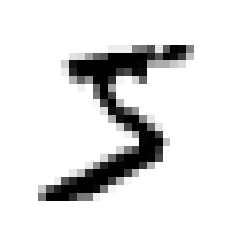

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 특정한 숫자 그려보기
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
# 해당 숫자 라벨링 확인
print("some_digit label: {}".format(y[0]))

some_digit label: 5


In [7]:
# 숫자형 데이터타입으로 변환
import numpy as np
y = y.astype(np.uint8)

In [8]:
# MNIST 데이터셋은 전체 7만개 데이터 중 앞부분 6만개는 트레이닝 데이터셋,
# 뒷부분 1만개는 테스트 데아터셋으로 구분한다.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
# 5만 검출하는 이진분류기 만들어보기
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
# some_digit의 라벨이 5이므로 결과 확인
sgd_clf.predict([some_digit])

array([ True])

In [11]:
# 사이킷런의 cross_val_score 함수를 직접 구현해보기
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

C:\Users\pacie\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [12]:
# 이번엔 사이킷런의 cross_val_score 함수로 평가하기
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# 정확도가 높게 나오는 것 같지만.. 사실은 아니다.
# 모든 이미지를 5로 분류하는 더미 분류기를 만들어보자
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [14]:
# 분류기의 성능을 평가하는 방법은 주로 Confusion Matrix를 사용한다.
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [15]:
# 완벽한 분류기인 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [16]:
# 정밀도(Precision)와 재현율(Recall)
# 정밀도 = TP / (TP + FP)
# 재현율 = TP / (TP + FN)
from sklearn.metrics import precision_score, recall_score
print("Precision {}".format(precision_score(y_train_5, y_train_pred)))
print("Recall {}".format(recall_score(y_train_5, y_train_pred)))


Precision 0.8370879772350012
Recall 0.6511713705958311


In [17]:
# F1-Score은 정밀도와 재현율의 조화평균으로 계산한다.
from sklearn.metrics import f1_score
print("F1-Score {}".format(f1_score(y_train_5, y_train_pred)))

F1-Score 0.7325171197343846


In [20]:
# 정밀도vs재현율 관계에서 임계값 이해한다.
y_scores = sgd_clf.decision_function([some_digit])
print("y scores {}".format(y_scores))
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print("y result {}".format(y_some_digit_pred))

y scores [2164.22030239]
y result [ True]


In [21]:
# 임계값을 높여본다.
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print("y result {}".format(y_some_digit_pred))

y result [False]


In [22]:
# 모든 트레이닝 데이터에 대해 점수(decision_function) 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

# 모든 임계값에 대한 정밀도, 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

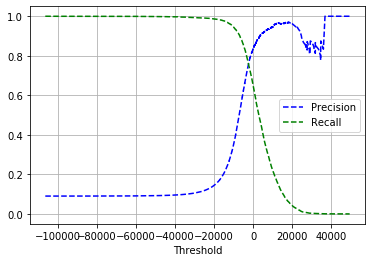

In [28]:
# 그래프 그려보기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

    plt.xlabel("Threshold")
    plt.legend()
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [29]:
# 정밀도가 90% 되는 임계값 찾기
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
# 이 값의 정밀도와 재현율 확인
print("Precision {}".format(precision_score(y_train_5, y_train_pred_90)))
print("Recall {}".format(recall_score(y_train_5, y_train_pred_90)))

Precision 0.9000345901072293
Recall 0.4799852425751706


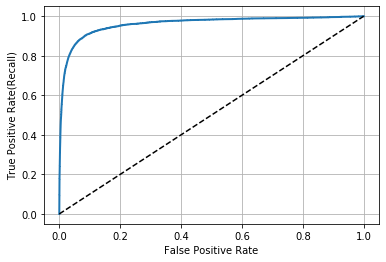

In [32]:
# ROC 커브 그리기
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate(Recall)")
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

In [33]:
# ROC 커브의 면적 구하기, 완벽한 분류기의 면적은 1.0이고, 완전한 랜덤 분류기는 0.5이다.
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [34]:
# RandomForestClassifier를 사용한 결과 확인
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

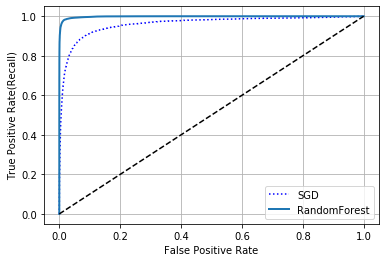

In [35]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# ROC 커브 그리기
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="RandomForest")
plt.legend(loc="lower right")
plt.show()

In [36]:
# 다중분류기 (지금까지는 숫자가 5인지, 아닌지만 분류했었다.)를 사용해보자.
# 이진분류기를 여러개 조합해서 다중분류를 수행하는 SVC를 해보자.
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
# decision_function()을 사용해서 각 클래스당 점수를 확인해보자.
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
